In [1]:
import curr_adventure as cad 
import jax.numpy as jnp
from jax import random as jrandom

from curr_adventure.derivative_estimation.one_E_zero import FD_1E0, SD_1E0
from utils import run_tests, mse_loss

from scipy.stats import linregress
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})

from jax.config import config
config.update("jax_enable_x64", True)

%load_ext autoreload

%autoreload 2

In [34]:
jrandom_key_w = jrandom.PRNGKey(1)
barrier_multiplier = 5

def LogPolytopeGetter(dim, noise=0):
    b = jnp.ones(dim*barrier_multiplier)
    w = jrandom.normal(jrandom_key_w, shape=(dim*barrier_multiplier, dim,)).dot(jnp.diag(jnp.linspace(0.1, 5, dim)))
#     w /= jnp.linalg.norm(w, axis=1).reshape(-1, 1)
    return cad.Barriers.LogPolytopeBarrier(w, b, noise)

funcs = {
    "LogPolytope": lambda dim: LogPolytopeGetter(dim, 0.001),
}

def config_creator(F, x_0, h, num_samples, hessian_geometry):
    config = {}
    config["N"] = num_samples
    config["h"] = h
    if hessian_geometry:
        config["cov"] = jnp.linalg.inv(F.f2(x_0.reshape(1, -1))[0])
#         print(jnp.linalg.eig(config["cov"]))
    else:
        config["cov"] = jnp.eye(x_0.shape[0])


    config["sample_subspace_basis"] = None
    config["F"] = F
#     config["distribution_name"] = "beta"
    config["is_uniform_sphere_random"] = False
    return config
    

fd_estimator = lambda F, x_0, h, num_samples, subkey: SD_1E0(F, x_0, config_creator(F, x_0, h, num_samples, False), subkey, sample_based=True)
sd_estimator = lambda F, x_0, h, num_samples, subkey: SD_1E0(F, x_0, config_creator(F, x_0, h, num_samples, True), subkey, sample_based=True)




seed = 0

standard_deviations = list(jnp.logspace(1.2, -5, 50)) # [100, 10, 1, 0.25, 0.1] 
dimensions = [500] # jnp.linspace(10, 200, 11, dtype=int) # [10] # [100] #






In [35]:
FD_logs = []
SD_logs = []
SSD_logs = []
x = 0.1
x_0_generator = lambda dim: x*jnp.ones(dim)/jnp.linalg.norm(jnp.ones(dim))

frac_samples = [2] # list(jnp.logspace(0.1, 1.5, 3))
num_runs = 1

FD_logs = run_tests(fd_estimator, funcs, x_0_generator, standard_deviations, dimensions, frac_samples, num_runs, seed, loss_type="MSE")
 
SD_logs = run_tests(sd_estimator, funcs, x_0_generator, standard_deviations, dimensions, frac_samples, num_runs, seed, loss_type="MSE")
    

100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


FD


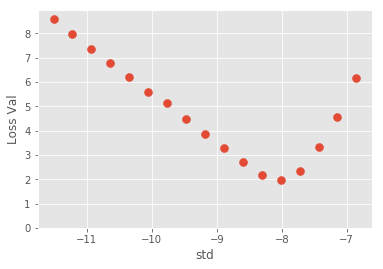

SD


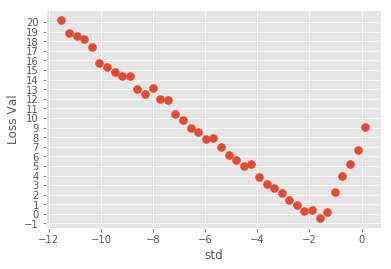

In [36]:


FD_means = FD_logs.mean_std()[0]
FD_std = FD_logs.mean_std()[1]

SD_means = SD_logs.mean_std()[0]
SD_std = SD_logs.mean_std()[1]


col_key = "std"

def plot_feature_loss(df_means, df_std, col_key, xscale=None, namename=None):
    df_means = df_means.stack().unstack(col_key)
    df_std = df_std.stack().unstack(col_key)
    for i in range(len(df_means)):
        idx = df_means.index[i]
#         slope, intercept, _, _, _ = linregress(jnp.log(df_means.columns.values), jnp.log(df_means.loc[idx].values))
#         plt.errorbar(df_means.columns.values, df_means.loc[idx].values, df_std.loc[idx].values, fmt='-o', capsize=5, label=str(idx) + "; slope:{:.2f}; intercept:{:.2f}".format(slope, intercept))
        plt.scatter(x=jnp.log(df_means.columns.values), y=jnp.log(df_means.loc[idx].values))


#     if xscale is not None:
#         plt.xscale(xscale)
#     plt.yscale("log")
    plt.xlabel(col_key)
    plt.ylabel("Loss Val")
    plt.yticks(jnp.arange(int(jnp.nanmin(jnp.log(df_means.values))) - 1, int(jnp.nanmax(jnp.log(df_means.values))) + 1, step=1))
#     plt.legend()
#     plt.savefig("figs/{}".format(namename))
    plt.show()


        
name = "QuarticDegenerate_dimension"
print("FD")
plot_feature_loss(FD_means, FD_std, col_key, "log", "FD_{}".format(name))
print("SD")
plot_feature_loss(SD_means, SD_std, col_key, "log", "Gauss_{}".format(name))
# print("SSD")
# plot_feature_loss(SSD_means, SSD_std, col_key, "log", "MC Gauss_{}".format(name))
    

In [107]:
dim = 50
F = LogPolytopeGetter(dim, 0)
F_noise = LogPolytopeGetter(dim, 0.1)
x_0 = x_0_generator(dim)
G = F.f1(x_0)

std = 0.007

jrandom_key, subkey = jrandom.split(jrandom_key)
G_approx_noise = FD_1E0(F_noise, x_0, std, 10, subkey)
G_approx = FD_1E0(F, x_0, std, 1, subkey)

print("Noise Loss", mse_loss(jnp.zeros(dim), G_approx_noise - G_approx))
print("Bias", mse_loss(G, G_approx))
print("Total Loss", mse_loss(G, G_approx_noise))


Noise Loss [9.917318181498427]
Bias [3.0284402787135807e-06]
Total Loss [9.917368824985688]


In [114]:
jrandom_key, subkey = jrandom.split(jrandom_key)
G_approx_noise = SD_1E0(F_noise, x_0, config_creator(F, x_0, std, dim*20), subkey, sample_based=True)
G_approx = SD_1E0(F, x_0, config_creator(F, x_0, std, dim*20), subkey, sample_based=True)

print("Noise Loss", mse_loss(jnp.zeros(dim), G_approx_noise - G_approx))
print("Bias/Variance", mse_loss(G, G_approx))
print("Total Loss", mse_loss(G, G_approx_noise))


Noise Loss [148.77960532977582]
Bias/Variance [0.1267893559267794]
Total Loss [147.42151832990658]


In [113]:
jrandom_key, subkey = jrandom.split(jrandom_key)
G_approx_noise = SD_1E0(F_noise, x_0, config_creator(F, x_0, std, dim*20, True), subkey, sample_based=True)
G_approx = SD_1E0(F, x_0, config_creator(F, x_0, std, dim*20, True), subkey, sample_based=True)

print("Noise Loss", mse_loss(jnp.zeros(dim), G_approx_noise - G_approx))
print("Bias/Variance", mse_loss(G, G_approx))
print("Total Loss", mse_loss(G, G_approx_noise))


Noise Loss [0.20188592356462062]
Bias/Variance [48.03205479591352]
Total Loss [49.18580277368678]


[[0.20885898 0.05499809]
 [0.05499809 0.09581994]]
[[0.20885898 0.05499809]
 [0.05499809 0.09581994]]
[0.23120166+0.j 0.07347726+0.j]


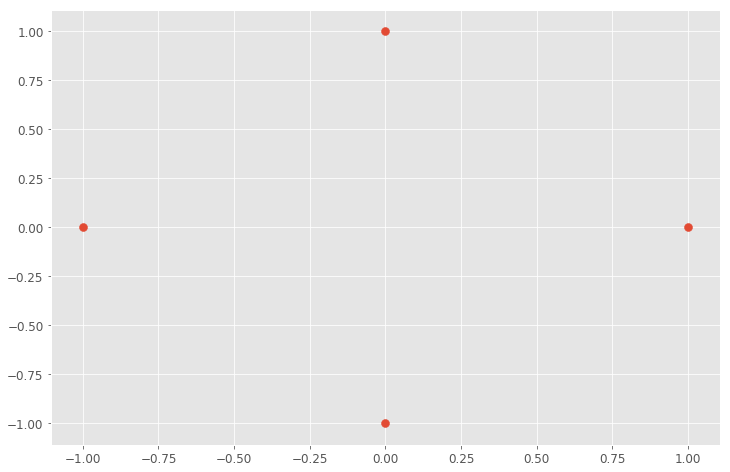

In [47]:
def generate_ellipse(dim, N, ellipse_M, is_uniform_sphere_random, jrandom_key): 

    # generate points on the sphere
    if is_uniform_sphere_random:
        dirs = jrandom.normal(jrandom_key, shape=(N, dim)) 
        dirs = dirs/jnp.linalg.norm(dirs, axis=1).reshape(-1, 1) * jnp.sqrt(dim)
    else:
        forwardX = jnp.eye(dim)
        backwardX = -jnp.eye(dim)

        num_dir_samples = N // (2 * dim)
        if num_dir_samples == 0:
            raise Exception("Given too few samples, {}, for Central Differences with dimension {}".format(N, dim))

        dirs = jnp.concatenate([jnp.tile(forwardX, (num_dir_samples, 1)), jnp.tile(backwardX, (num_dir_samples, 1))])

    # transform sphere to ellipse
    if ellipse_M is not None:
        L = jnp.linalg.cholesky(ellipse_M)
        dirs = dirs.dot(L.T)

    return dirs 


F = funcs["LogPolytope"](2)
N = 4
x_0 = x_0_generator(2)
ellipse_M = jnp.linalg.inv(F.f2(x_0.reshape(1, -1))[0])
circle_M = jnp.eye(2)
d = generate_ellipse(2, N, circle_M, False, jrandom_key_w)

# de = 
L  = jnp.linalg.cholesky(ellipse_M)
print(L.dot(L.T))
print(ellipse_M)
print(jnp.linalg.eigvals(ellipse_M))


plt.scatter(d[:, 0], d[:, 1])